# JAX + Triton Flash Attention


Copyright 2022 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

## Installs

In [ ]:
!pip install -U --pre triton
!pip install chex
!pip install cmake

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.7 MB 1.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 618 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title Install JAX + Triton { vertical-output: true }
%cd /root
!pip uninstall jax -y
!git clone https://github.com/sharadmv/jax.git
%cd jax
!git checkout triton
!pip install -I -U ".[cuda11_cudnn82]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install pybind11
%cd triton
!make
!pip install .
%cd /root

/root
Found existing installation: jax 0.3.14
Uninstalling jax-0.3.14:
  Successfully uninstalled jax-0.3.14
Cloning into 'jax'...
remote: Enumerating objects: 72139, done.
remote: Counting objects: 100% (269/269), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 72139 (delta 159), reused 215 (delta 135), pack-reused 71870
Receiving objects: 100% (72139/72139), 52.81 MiB | 17.69 MiB/s, done.
Resolving deltas: 100% (56480/56480), done.
/root/jax
Branch 'triton' set up to track remote branch 'triton' from 'origin'.
Switched to a new branch 'triton'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
Processing /root/jax
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new beh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 213 kB 7.8 MB/s 
/root/jax/triton
g++ --std=c++17 custom_call.cc -o jax_triton/custom_call.so -L/usr/local/cuda/lib64 -L/usr/local/cuda/lib64/stubs -shared -fPIC -I/usr/include/python3.7m -I/usr/local/lib/python3.7/dist-packages/pybind11/include -I/usr/local/cuda/include -lcuda -fpermissive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /root/jax/triton
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Get

## Imports

In [ ]:
import jax
import jax.numpy as jnp
import chex
import numpy as np
import time

import pytest
import torch

import triton
import triton.language as tl

# Verify GPU type
!nvidia-smi

Tue Jul 26 01:09:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Attention

## Triton Flash Attention

FlashAttention was added recently to OpenAI Triton (https://github.com/openai/triton/issues/540#issuecomment-1170219125 and implementation https://github.com/openai/triton/blob/master/python/tutorials/06-fused-attention.py). This is just the copy-pasted implementation:

In [ ]:
@triton.jit
def _fwd_kernel(
    Q, K, V,
    TMP, L, M,  # NOTE: TMP is a scratchpad buffer to workaround a compiler bug
    Out,
    stride_qz, stride_qh, stride_qm, stride_qk,
    stride_kz, stride_kh, stride_kk, stride_kn,
    stride_vz, stride_vh, stride_vk, stride_vn,
    stride_oz, stride_oh, stride_om, stride_on,
    Z, H, N_CTX,
    BLOCK_M: tl.constexpr, BLOCK_DMODEL: tl.constexpr,
    BLOCK_N: tl.constexpr,
):
    start_qm = tl.program_id(0)
    off_hz = tl.program_id(1)
    # initialize offsets
    offs_m = start_qm * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_n = tl.arange(0, BLOCK_N)
    offs_d = tl.arange(0, BLOCK_DMODEL)
    off_q = off_hz * stride_qh + offs_m[:, None] * stride_qm + offs_d[None, :] * stride_qk
    off_k = off_hz * stride_qh + offs_n[None, :] * stride_kn + offs_d[:, None] * stride_kk
    off_v = off_hz * stride_qh + offs_n[:, None] * stride_qm + offs_d[None, :] * stride_qk
    # Initialize pointers to Q, K, V
    q_ptrs = Q + off_q
    k_ptrs = K + off_k
    v_ptrs = V + off_v
    # initialize pointer to m and l
    t_ptrs = TMP + off_hz * N_CTX + offs_m

    acc = tl.zeros([BLOCK_M, BLOCK_DMODEL], dtype=tl.float32)
    m_i = tl.zeros([BLOCK_M], dtype=tl.float32) - float("inf")
    l_i = tl.zeros([BLOCK_M], dtype=tl.float32)

    q = tl.load(q_ptrs)
    for start_n in range(0, start_qm + 1):
        # -- compute qk ----
        k = tl.load(k_ptrs)
        qk = tl.dot(q, k)
        qk += tl.where(offs_m[:, None] >= (start_n * BLOCK_N + offs_n[None, :]), 0, float("-inf"))
        # -- compute m_ij, p, l_ij
        m_ij = tl.max(qk, 1)
        p = tl.exp(qk - m_ij[:, None])
        l_ij = tl.sum(p, 1)
        # -- update m_i and l_i
        m_i_new = tl.maximum(m_i, m_ij)
        alpha = tl.exp(m_i - m_i_new)
        beta = tl.exp(m_ij - m_i_new)
        l_i_new = alpha * l_i + beta * l_ij
        # -- update output accumulator --
        # scale p
        p_scale = beta / l_i_new
        p = p * p_scale[:, None]
        p = p.to(tl.float16)
        # scale acc
        acc_scale = l_i / l_i_new * alpha
        tl.store(t_ptrs, acc_scale)
        acc_scale = tl.load(t_ptrs)  # BUG: have to store and immediately load
        acc = acc * acc_scale[:, None]
        # update acc
        v = tl.load(v_ptrs)
        acc += tl.dot(p, v)
        k_ptrs += BLOCK_N * stride_kn
        v_ptrs += BLOCK_N * stride_vk
        # r_ptrs += BLOCK_N
        l_i = l_i_new
        m_i = m_i_new

    start_qm = tl.program_id(0)
    offs_m = start_qm * BLOCK_M + tl.arange(0, BLOCK_M)
    # write back l and m
    l_ptrs = L + off_hz * N_CTX + offs_m
    m_ptrs = M + off_hz * N_CTX + offs_m
    tl.store(l_ptrs, l_i)
    tl.store(m_ptrs, m_i)
    # initialize pointers to output
    offs_n = tl.arange(0, BLOCK_DMODEL)
    off_out = off_hz * stride_oh + offs_m[:, None] * stride_om + offs_n[None, :] * stride_on
    out_ptrs = Out + off_out
    tl.store(out_ptrs, acc)


class _attention(torch.autograd.Function):

    @staticmethod
    def forward(ctx, q, k, v):
        BLOCK = 128
        # shape constraints
        Lq, Lk = q.shape[-1], k.shape[-2]
        assert Lq == Lk
        o = torch.empty_like(q)
        grid = (triton.cdiv(q.shape[2], BLOCK), q.shape[0] * q.shape[1])
        tmp = torch.empty((q.shape[0] * q.shape[1], q.shape[2]), device=q.device, dtype=torch.float32)
        L = torch.empty((q.shape[0] * q.shape[1], q.shape[2]), device=q.device, dtype=torch.float32)
        m = torch.empty((q.shape[0] * q.shape[1], q.shape[2]), device=q.device, dtype=torch.float32)
        _fwd_kernel[grid](
            q, k, v,
            tmp, L, m,
            o,
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),
            o.stride(0), o.stride(1), o.stride(2), o.stride(3),
            q.shape[0], q.shape[1], q.shape[2],
            BLOCK_M=BLOCK, BLOCK_N=BLOCK,
            BLOCK_DMODEL=64, num_warps=4,
            num_stages=1,
        )
        ctx.save_for_backward(q, k, v, o, L, m)
        ctx.BLOCK = BLOCK
        ctx.grid = grid
        return o


attention = _attention.apply


@pytest.mark.parametrize('Z, H, N_CTX, D_MODEL', [(2, 3, 1024, 64)])
def test_op(Z, H, N_CTX, D_MODEL, dtype=torch.float16):
    torch.manual_seed(20)
    q = .5 * torch.randn((Z, H, N_CTX, D_MODEL), dtype=dtype, device="cuda", requires_grad=True)
    k = .5 * torch.randn((Z, H, D_MODEL, N_CTX), dtype=dtype, device="cuda", requires_grad=True)
    v = .5 * torch.randn((Z, H, N_CTX, D_MODEL), dtype=dtype, device="cuda", requires_grad=True)
    # triton implementation
    tri_out = attention(q, k, v)
    # reference implementation
    M = torch.tril(torch.ones((N_CTX, N_CTX), device="cuda"))
    ref_qk = torch.matmul(q, k)
    for z in range(Z):
        for h in range(H):
            ref_qk[:, :, M == 0] = float("-inf")
    ref_qk = torch.softmax(ref_qk, dim=-1)
    ref_out = torch.matmul(ref_qk, v)
    # compare
    triton.testing.assert_almost_equal(ref_out, tri_out)


try:
    from flash_attn.flash_attn_interface import flash_attn_func
    HAS_FLASH = True
except BaseException:
    HAS_FLASH = False

BATCH, N_HEADS, N_CTX, D_HEAD = 4, 64, 2048, 64
# vary batch size for fixed heads / seq
batch_bench = triton.testing.Benchmark(
    x_names=['BATCH'],
    x_vals=[2**i for i in range(0, 8)],
    line_arg='provider',
    line_vals=['triton'] + (['flash'] if HAS_FLASH else []),
    line_names=['Triton'] + (['Flash'] if HAS_FLASH else []),
    styles=[('red', '-'), ('blue', '-')],
    ylabel='ms',
    plot_name=f'fused-attention-seq{N_CTX}-head{N_HEADS}-d{D_HEAD}',
    args={'H': N_HEADS, 'N_CTX': N_CTX, 'D_MODEL': D_HEAD, 'dtype': torch.float16}
)
# vary seq length for fixed head and batch=4
seq_bench = triton.testing.Benchmark(
    x_names=['N_CTX'],
    x_vals=[2**i for i in range(10, 16)],
    line_arg='provider',
    line_vals=['triton'] + (['flash'] if HAS_FLASH else []),
    line_names=['Triton'] + (['Flash'] if HAS_FLASH else []),
    styles=[('red', '-'), ('blue', '-')],
    ylabel='ms',
    plot_name=f'fused-attention-batch{BATCH}-head{N_HEADS}-d{D_HEAD}',
    args={'H': D_HEAD, 'BATCH': BATCH, 'D_MODEL': D_HEAD, 'dtype': torch.float16}
)


@triton.testing.perf_report([batch_bench, seq_bench])
def bench_flash_attention(BATCH, H, N_CTX, D_MODEL, provider, dtype=torch.float16, device="cuda"):
    warmup = 25
    rep = 500
    if provider == "triton":
        q = torch.randn((BATCH, H, N_CTX, D_MODEL), dtype=dtype, device="cuda", requires_grad=True)
        k = torch.randn((BATCH, H, D_MODEL, N_CTX), dtype=dtype, device="cuda", requires_grad=True)
        v = torch.randn((BATCH, H, N_CTX, D_MODEL), dtype=dtype, device="cuda", requires_grad=True)
        fn = lambda: attention(q, k, v)
        ms = triton.testing.do_bench(fn, percentiles=None, warmup=warmup, rep=rep)
        return ms
    if provider == "flash":
        lengths = torch.full((BATCH,), fill_value=N_CTX, device=device)
        cu_seqlens = torch.zeros((BATCH + 1,), device=device, dtype=torch.int32)
        cu_seqlens[1:] = lengths.cumsum(0)
        qkv = torch.randn((BATCH * N_CTX, 3, H, D_MODEL), dtype=dtype, device=device, requires_grad=True)
        fn = lambda: flash_attn_func(qkv, cu_seqlens, 0., N_CTX, causal=True)
        ms = triton.testing.do_bench(fn, percentiles=None, warmup=warmup, rep=rep)
        return ms


#bench_flash_attention.run(save_path='.', print_data=True)

## JAX

Verify equivalence to JAX:

In [ ]:
from types import SimpleNamespace
import jax_triton as jt

import jax
import jax.numpy as jnp
from jax import random
import numpy as np

def _strides(shape):
  all = np.prod(shape)
  for s in shape:
    all = all // s
    yield int(all)

@triton.jit
def fused_attention_kernel(
    Q, K, V,
    TMP, L, M,  # NOTE: TMP is a scratchpad buffer to workaround a compiler bug
    Out,
    stride_qz: tl.constexpr, stride_qh: tl.constexpr, stride_qm: tl.constexpr, stride_qk: tl.constexpr,
    stride_kz: tl.constexpr, stride_kh: tl.constexpr, stride_kk: tl.constexpr, stride_kn: tl.constexpr,
    stride_vz: tl.constexpr, stride_vh: tl.constexpr, stride_vk: tl.constexpr, stride_vn: tl.constexpr,
    stride_oz: tl.constexpr, stride_oh: tl.constexpr, stride_om: tl.constexpr, stride_on: tl.constexpr,
    Z: tl.constexpr, H: tl.constexpr, N_CTX: tl.constexpr,
    BLOCK_M: tl.constexpr, BLOCK_DMODEL: tl.constexpr,
    BLOCK_N: tl.constexpr,
):
    start_qm = tl.program_id(0)
    off_hz = tl.program_id(1)
    # initialize offsets
    offs_m = start_qm * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_n = tl.arange(0, BLOCK_N)
    offs_d = tl.arange(0, BLOCK_DMODEL)
    off_q = off_hz * stride_qh + offs_m[:, None] * stride_qm + offs_d[None, :] * stride_qk
    off_k = off_hz * stride_qh + offs_n[None, :] * stride_kn + offs_d[:, None] * stride_kk
    off_v = off_hz * stride_qh + offs_n[:, None] * stride_qm + offs_d[None, :] * stride_qk
    # Initialize pointers to Q, K, V
    q_ptrs = Q + off_q
    k_ptrs = K + off_k
    v_ptrs = V + off_v
    # initialize pointer to m and l
    t_ptrs = TMP + off_hz * N_CTX + offs_m

    acc = tl.zeros([BLOCK_M, BLOCK_DMODEL], dtype=tl.float32)
    m_i = tl.zeros([BLOCK_M], dtype=tl.float32) - float("inf")
    l_i = tl.zeros([BLOCK_M], dtype=tl.float32)

    q = tl.load(q_ptrs)
    for start_n in range(0, start_qm + 1):
        # -- compute qk ----
        k = tl.load(k_ptrs)
        qk = tl.dot(q, k)
        qk += tl.where(offs_m[:, None] >= (start_n * BLOCK_N + offs_n[None, :]), 0, float("-inf"))
        # -- compute m_ij, p, l_ij
        m_ij = tl.max(qk, 1)
        p = tl.exp(qk - m_ij[:, None])
        l_ij = tl.sum(p, 1)
        # -- update m_i and l_i
        m_i_new = tl.maximum(m_i, m_ij)
        alpha = tl.exp(m_i - m_i_new)
        beta = tl.exp(m_ij - m_i_new)
        l_i_new = alpha * l_i + beta * l_ij
        # -- update output accumulator --
        # scale p
        p_scale = beta / l_i_new
        p = p * p_scale[:, None]
        p = p.to(tl.float16)
        # scale acc
        acc_scale = l_i / l_i_new * alpha
        tl.store(t_ptrs, acc_scale)
        acc_scale = tl.load(t_ptrs)  # BUG: have to store and immediately load
        acc = acc * acc_scale[:, None]
        # update acc
        v = tl.load(v_ptrs)
        acc += tl.dot(p, v)
        k_ptrs += BLOCK_N * stride_kn
        v_ptrs += BLOCK_N * stride_vk
        # r_ptrs += BLOCK_N
        l_i = l_i_new
        m_i = m_i_new

    start_qm = tl.program_id(0)
    offs_m = start_qm * BLOCK_M + tl.arange(0, BLOCK_M)
    # write back l and m
    l_ptrs = L + off_hz * N_CTX + offs_m
    m_ptrs = M + off_hz * N_CTX + offs_m
    tl.store(l_ptrs, l_i)
    tl.store(m_ptrs, m_i)
    # initialize pointers to output
    offs_n = tl.arange(0, BLOCK_DMODEL)
    off_out = off_hz * stride_oh + offs_m[:, None] * stride_om + offs_n[None, :] * stride_on
    out_ptrs = Out + off_out
    tl.store(out_ptrs, acc)
    
@jax.jit
def jax_attention_triton(q: jnp.ndarray, k: jnp.ndarray, v: jnp.ndarray) -> jnp.ndarray:
  BLOCK = 128
  Lq, Lk = q.shape[-1], k.shape[-2]
  assert Lq == Lk
  grid = lambda _: (triton.cdiv(q.shape[2], BLOCK), q.shape[0] * q.shape[1])
  out_shape = [
      SimpleNamespace(shape=(q.shape[0] * q.shape[1], q.shape[2]), dtype=q.dtype),
      SimpleNamespace(shape=(q.shape[0] * q.shape[1], q.shape[2]), dtype=q.dtype),
      SimpleNamespace(shape=(q.shape[0] * q.shape[1], q.shape[2]), dtype=q.dtype),
      SimpleNamespace(shape=q.shape, dtype=q.dtype)]
  stride_qz, stride_qh, stride_qm, stride_qk = _strides(q.shape)
  stride_kz, stride_kh, stride_kk, stride_kn = _strides(k.shape)
  stride_vz, stride_vh, stride_vk, stride_vn = _strides(v.shape)
  stride_oz, stride_oh, stride_om, stride_on = _strides(out_shape[-1].shape)
  
  metaparams = dict(
    BLOCK_M=BLOCK,
    BLOCK_N=BLOCK,
    BLOCK_DMODEL=64,
    stride_qz=stride_qz, stride_qh=stride_qh, stride_qm=stride_qm, stride_qk=stride_qk,
    stride_kz=stride_kz, stride_kh=stride_kh, stride_kk=stride_kk, stride_kn=stride_kn,
    stride_vz=stride_vz, stride_vh=stride_vh, stride_vk=stride_vk, stride_vn=stride_vn,
    stride_oz=stride_oz, stride_oh=stride_oh, stride_om=stride_om, stride_on=stride_on,
    Z=q.shape[0], H=q.shape[1], N_CTX=q.shape[2],
    num_warps=4, num_stages=1
  )
  _, _, _, output = jt.triton_call(q, k, v, kernel=fused_attention_kernel,
      out_shape=out_shape, grid=grid, **metaparams)
  return output

@jax.jit
def jax_attention(q, k, v):
  n_seq = q.shape[-2]
  logits = jnp.matmul(q, k)
  mask = jnp.tril(jnp.ones((1, 1, n_seq, n_seq), dtype=q.dtype))
  mask = jnp.broadcast_to(mask, logits.shape)
  logits = jnp.where(mask, logits, float('-inf'))
  ref_qk = jax.nn.softmax(logits)
  return jnp.matmul(ref_qk, v)

def test_triton_jax(batch, heads, seq_len, d_model, dtype=torch.float16):
  torch.manual_seed(20)
  q = .5 * torch.randn((batch, heads, seq_len, d_model), dtype=dtype, device="cuda", requires_grad=True)
  k = .5 * torch.randn((batch, heads, d_model, seq_len), dtype=dtype, device="cuda", requires_grad=True)
  v = .5 * torch.randn((batch, heads, seq_len, d_model), dtype=dtype, device="cuda", requires_grad=True)
  # triton implementation
  tri_out = attention(q, k, v).cpu().detach().numpy()

  q_jax = jnp.array(q.cpu().detach().numpy(), dtype=jnp.float16)
  del q
  k_jax = jnp.array(k.cpu().detach().numpy(), dtype=jnp.float16)
  del k
  v_jax = jnp.array(v.cpu().detach().numpy(), dtype=jnp.float16)
  del v

  jax_out = jax_attention(q_jax, k_jax, v_jax)
  chex.assert_trees_all_close(tri_out, jax_out, atol=0.003)
  jax_out = jax_attention_triton(q_jax, k_jax, v_jax)
  chex.assert_trees_all_close(tri_out, jax_out, atol=0.003)

test_triton_jax(2, 32, 2048, 64)

The setup `BATCH, N_HEADS, N_CTX, D_HEAD = 8, 4, 2048, 64` took 2.44ms on Triton based on timings above, as speedup of 8x:

In [ ]:
BATCH, N_HEADS, N_CTX, D_HEAD = 8, 64, 2048, 64


# warmup
def bench_jax_triton(batch, heads, seq_len, d_model):
  q_jax = jnp.ones((batch, heads, seq_len, d_model), dtype=jnp.float16)
  k_jax = jnp.ones((batch, heads, d_model, seq_len), dtype=jnp.float16)
  v_jax = jnp.ones((batch, heads, seq_len, d_model), dtype=jnp.float16)
  # warmup
  jax_attention_triton(q_jax, k_jax, q_jax).block_until_ready()
  jax_attention_triton(q_jax, k_jax, q_jax).block_until_ready()

  t1 = time.time()
  num_runs = 100
  for _ in range(num_runs):
    jax_attention_triton(q_jax, k_jax, q_jax).block_until_ready()
  estimate_ms = 1000 * (time.time() - t1) / num_runs
  return estimate_ms

print(bench_jax_triton(batch=BATCH, heads=N_HEADS, seq_len=N_CTX, d_model=D_HEAD))

# warmup
def bench_jax(batch, heads, seq_len, d_model):
  q_jax = jnp.ones((batch, heads, seq_len, d_model), dtype=jnp.float16)
  k_jax = jnp.ones((batch, heads, d_model, seq_len), dtype=jnp.float16)
  v_jax = jnp.ones((batch, heads, seq_len, d_model), dtype=jnp.float16)
  # warmup
  jax_attention(q_jax, k_jax, q_jax).block_until_ready()
  jax_attention(q_jax, k_jax, q_jax).block_until_ready()

  t1 = time.time()
  num_runs = 100
  for _ in range(num_runs):
    jax_attention(q_jax, k_jax, q_jax).block_until_ready()
  estimate_ms = 1000 * (time.time() - t1) / num_runs
  return estimate_ms

print(bench_jax(batch=BATCH, heads=N_HEADS, seq_len=N_CTX, d_model=D_HEAD))

35.6231689453125
110.03916501998901


Rather than using the official Triton benchmarking utils, do a sanity check:

In [ ]:
def bench_triton(batch, heads, seq_len, d_model):
  dtype = torch.float16
  warmup = 25
  rep = 500
  q = torch.randn((batch, heads, seq_len, d_model), dtype=dtype, device="cuda", requires_grad=True)
  k = torch.randn((batch, heads, d_model, seq_len), dtype=dtype, device="cuda", requires_grad=True)
  v = torch.randn((batch, heads, seq_len, d_model), dtype=dtype, device="cuda", requires_grad=True)
  fn = lambda: attention(q, k, v)

  # Warmup
  fn()
  fn()
  torch.cuda.synchronize()
  t1 = time.time()
  num_runs = 100
  for _ in range(num_runs):
      fn()
  torch.cuda.synchronize()
  estimate_ms = 1000 * (time.time() - t1) / num_runs
  return estimate_ms

bench_triton(batch=BATCH, heads=N_HEADS, seq_len=N_CTX, d_model=D_HEAD)

33.43979358673096

Plot:

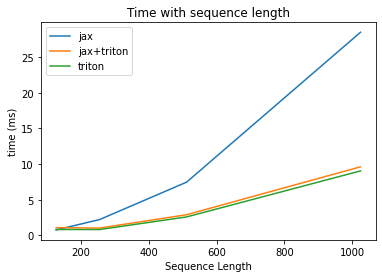

In [ ]:
import matplotlib.pyplot as plt

seq_lens = [128, 256, 512, 1024]
y_jax, y_jax_triton, y_trit = [], [], []

for s in seq_lens:
  y_jax.append(bench_jax(batch=BATCH, heads=N_HEADS, seq_len=s, d_model=D_HEAD))
  y_jax_triton.append(bench_jax_triton(batch=BATCH, heads=N_HEADS, seq_len=s, d_model=D_HEAD))
  y_trit.append(bench_triton(batch=BATCH, heads=N_HEADS, seq_len=s, d_model=D_HEAD))

plt.plot(seq_lens, y_jax, label='jax')
plt.plot(seq_lens, y_jax_triton, label='jax+triton')
plt.plot(seq_lens, y_trit, label='triton')
plt.title('Time with sequence length')
plt.ylabel('time (ms)')
plt.xlabel('Sequence Length')
plt.legend()
plt.show()